In [1]:
# Google Colab에서 노트북을 실행하실 때에는 
# https://tutorials.pytorch.kr/beginner/colab 를 참고하세요.
%matplotlib inline


# 분류기(Classifier) 학습하기

지금까지 어떻게 신경망을 정의하고, 손실을 계산하며 또 가중치를 갱신하는지에
대해서 배웠습니다.

이제 아마도 이런 생각을 하고 계실텐데요,

## 데이터는 어떻게 하나요?

일반적으로 이미지나 텍스트, 오디오나 비디오 데이터를 다룰 때는 표준 Python 패키지를
이용하여 NumPy 배열로 불러오면 됩니다. 그 후 그 배열을 ``torch.*Tensor`` 로 변환합니다.

-  이미지는 Pillow나 OpenCV 같은 패키지가 유용합니다.
-  오디오를 처리할 때는 SciPy와 LibROSA가 유용하고요.
-  텍스트의 경우에는 그냥 Python이나 Cython을 사용해도 되고, NLTK나 SpaCy도
   유용합니다.

특별히 영상 분야를 위한 ``torchvision`` 이라는 패키지가 만들어져 있는데,
여기에는 ImageNet이나 CIFAR10, MNIST 등과 같이 일반적으로 사용하는 데이터셋을 위한
데이터 로더(data loader), 즉 ``torchvision.datasets`` 과 이미지용 데이터 변환기
(data transformer), 즉 ``torch.utils.data.DataLoader`` 가 포함되어 있습니다.

이러한 기능은 엄청나게 편리하며, 매번 유사한 코드(boilerplate code)를 반복해서
작성하는 것을 피할 수 있습니다.

이 튜토리얼에서는 CIFAR10 데이터셋을 사용합니다. 여기에는 다음과 같은 분류들이
있습니다: '비행기(airplane)', '자동차(automobile)', '새(bird)', '고양이(cat)',
'사슴(deer)', '개(dog)', '개구리(frog)', '말(horse)', '배(ship)', '트럭(truck)'.
그리고 CIFAR10에 포함된 이미지의 크기는 3x32x32로, 이는 32x32 픽셀 크기의 이미지가
3개 채널(channel)의 색상으로 이뤄져 있다는 것을 뜻합니다.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


## 이미지 분류기 학습하기

다음과 같은 단계로 진행해보겠습니다:

1. ``torchvision`` 을 사용하여 CIFAR10의 학습용 / 시험용 데이터셋을
   불러오고, 정규화(nomarlizing)합니다.
2. 합성곱 신경망(Convolution Neural Network)을 정의합니다.
3. 손실 함수를 정의합니다.
4. 학습용 데이터를 사용하여 신경망을 학습합니다.
5. 시험용 데이터를 사용하여 신경망을 검사합니다.

### 1. CIFAR10을 불러오고 정규화하기

``torchvision`` 을 사용하여 매우 쉽게 CIFAR10을 불러올 수 있습니다.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Othe

torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지입니다.
이를 [-1, 1]의 범위로 정규화된 Tensor로 변환합니다.

<div class="alert alert-info"><h4>Note</h4><p>만약 Windows 환경에서 BrokenPipeError가 발생한다면,
    torch.utils.data.DataLoader()의 num_worker를 0으로 설정해보세요.</p></div>



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:17<00:00, 9541882.71it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


재미삼아 학습용 이미지 몇 개를 보겠습니다.



/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

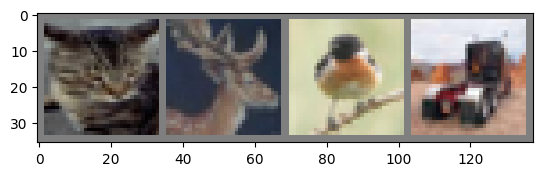

cat   deer  bird  truck


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. 합성곱 신경망(Convolution Neural Network) 정의하기
이전의 신경망 섹션에서 신경망을 복사한 후, (기존에 1채널 이미지만 처리하도록
정의된 것을) 3채널 이미지를 처리할 수 있도록 수정합니다.



In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. 손실 함수와 Optimizer 정의하기
교차 엔트로피 손실(Cross-Entropy loss)과 모멘텀(momentum) 값을 갖는 SGD를 사용합니다.



In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. 신경망 학습하기

이제 재미있는 부분이 시작됩니다.
단순히 데이터를 반복해서 신경망에 입력으로 제공하고, 최적화(Optimize)만 하면
됩니다.



In [9]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

[1,  2000] loss: 2.239
[1,  4000] loss: 1.923
[1,  6000] loss: 1.702
[1,  8000] loss: 1.603
[1, 10000] loss: 1.517
[1, 12000] loss: 1.476


/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

[2,  2000] loss: 1.439
[2,  4000] loss: 1.406
[2,  6000] loss: 1.366
[2,  8000] loss: 1.327
[2, 10000] loss: 1.302
[2, 12000] loss: 1.298
Finished Training


학습한 모델을 저장해보겠습니다:



In [10]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

PyTorch 모델을 저장하는 자세한 방법은 [여기](https://pytorch.org/docs/stable/notes/serialization.html)
를 참조해주세요.

### 5. 시험용 데이터로 신경망 검사하기

지금까지 학습용 데이터셋을 2회 반복하며 신경망을 학습시켰습니다.
신경망이 전혀 배운게 없을지도 모르니 확인해봅니다.

신경망이 예측한 출력과 진짜 정답(Ground-truth)을 비교하는 방식으로 확인합니다.
만약 예측이 맞다면 샘플을 '맞은 예측값(correct predictions)' 목록에 넣겠습니다.

첫번째로 시험용 데이터를 좀 보겠습니다.



/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

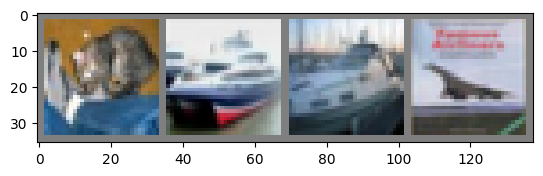

GroundTruth:  cat   ship  ship  plane


In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

이제, 저장했던 모델을 불러오도록 하겠습니다 (주: 모델을 저장하고 다시 불러오는
작업은 여기에서는 불필요하지만, 어떻게 하는지 설명을 위해 해보겠습니다):



In [12]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

좋습니다, 이제 이 예제들을 신경망이 어떻게 예측했는지를 보겠습니다:



In [17]:
outputs = net(images)

출력은 10개 분류 각각에 대한 값으로 나타납니다. 어떤 분류에 대해서 더 높은 값이
나타난다는 것은, 신경망이 그 이미지가 해당 분류에 더 가깝다고 생각한다는 것입니다.
따라서, 가장 높은 값을 갖는 인덱스(index)를 뽑아보겠습니다:



In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  plane deer  dog   truck


결과가 괜찮아보이네요.

그럼 전체 데이터셋에 대해서는 어떻게 동작하는지 보겠습니다.



In [14]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

Accuracy of the network on the 10000 test images: 56 %


(10가지 분류 중에 하나를 무작위로) 찍었을 때의 정확도인 10% 보다는 나아보입니다.
신경망이 뭔가 배우긴 한 것 같네요.

그럼 어떤 것들을 더 잘 분류하고, 어떤 것들을 더 못했는지 알아보겠습니다:



In [15]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

Accuracy for class: plane is 65.6 %
Accuracy for class: car   is 70.7 %
Accuracy for class: bird  is 40.9 %
Accuracy for class: cat   is 39.9 %
Accuracy for class: deer  is 50.9 %
Accuracy for class: dog   is 52.7 %
Accuracy for class: frog  is 63.5 %
Accuracy for class: horse is 61.0 %
Accuracy for class: ship  is 63.4 %
Accuracy for class: truck is 55.4 %


자, 이제 다음으로 무엇을 해볼까요?

이러한 신경망들을 GPU에서 실행하려면 어떻게 해야 할까요?

## GPU에서 학습하기
Tensor를 GPU로 이동했던 것처럼, 신경망 또한 GPU로 옮길 수 있습니다.

먼저 (CUDA를 사용할 수 있다면) 첫번째 CUDA 장치를 사용하도록 설정합니다:



In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다:

print(device)

cpu


이 섹션의 나머지 부분에서는 ``device`` 를 CUDA 장치라고 가정하겠습니다.

그리고 이 메소드(Method)들은 재귀적으로 모든 모듈의 매개변수와 버퍼를
CUDA tensor로 변경합니다:

.. code:: python

    net.to(device)


또한, 각 단계에서 입력(input)과 정답(target)도 GPU로 보내야 한다는 것도 기억해야
합니다:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

CPU와 비교했을 때 어마어마한 속도 차이가 나지 않는 것은 왜 그럴까요?
그 이유는 바로 신경망이 너무 작기 때문입니다.

**연습:** 신경망의 크기를 키워보고, 얼마나 빨라지는지 확인해보세요.
(첫번째 ``nn.Conv2d`` 의 2번째 인자와 두번째 ``nn.Conv2d`` 의 1번째 인자는
같은 숫자여야 합니다.)

**다음 목표들을 달성했습니다**:

- 높은 수준에서 PyTorch의 Tensor library와 신경망을 이해합니다.
- 이미지를 분류하는 작은 신경망을 학습시킵니다.

## 여러개의 GPU에서 학습하기
모든 GPU를 활용해서 더욱 더 속도를 올리고 싶다면, :doc:`data_parallel_tutorial`
을 참고하세요.

## 이제 무엇을 해볼까요?

-  :doc:`비디오 게임을 할 수 있는 신경망 학습시키기 </intermediate/reinforcement_q_learning>`
-  `imagenet으로 최첨단(state-of-the-art) ResNet 신경망 학습시키기`_
-  `적대적 생성 신경망으로 얼굴 생성기 학습시키기`_
-  `순환 LSTM 네트워크를 사용해 단어 단위 언어 모델 학습시키기`_
-  `다른 예제들 참고하기`_
-  `더 많은 튜토리얼 보기`_
-  `포럼에서 PyTorch에 대해 얘기하기`_
-  `Slack에서 다른 사용자와 대화하기`_




In [ ]:
del dataiter